# House Price Prediction - California dataset

#### Machine Learning Checklist:
1. Frame the problem and look at the big piture
2. Get the data
3. Explore the data to gain insights
4. Prepare/Preprocess the data for machine leaning algorithms
5. Explore many different models and shortlist best ones
6. Fine-tune the models
7. Present the solution
8. Launch, monitor and maintain the system

### Framing the problem

    The problem is indeed a supervised learning | regression task | with batch learning
<br>
    The data is quite small hence it can be stored in the system's memory. Hence, batch learning seems a good approach

In [1]:
from pathlib import Path
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

import tarfile
import urllib.request

import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

In [79]:
# Helper functions

def logger(message, value):
    print(f"{message}\n {value}")

In [2]:
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

### Initial data analysis


In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


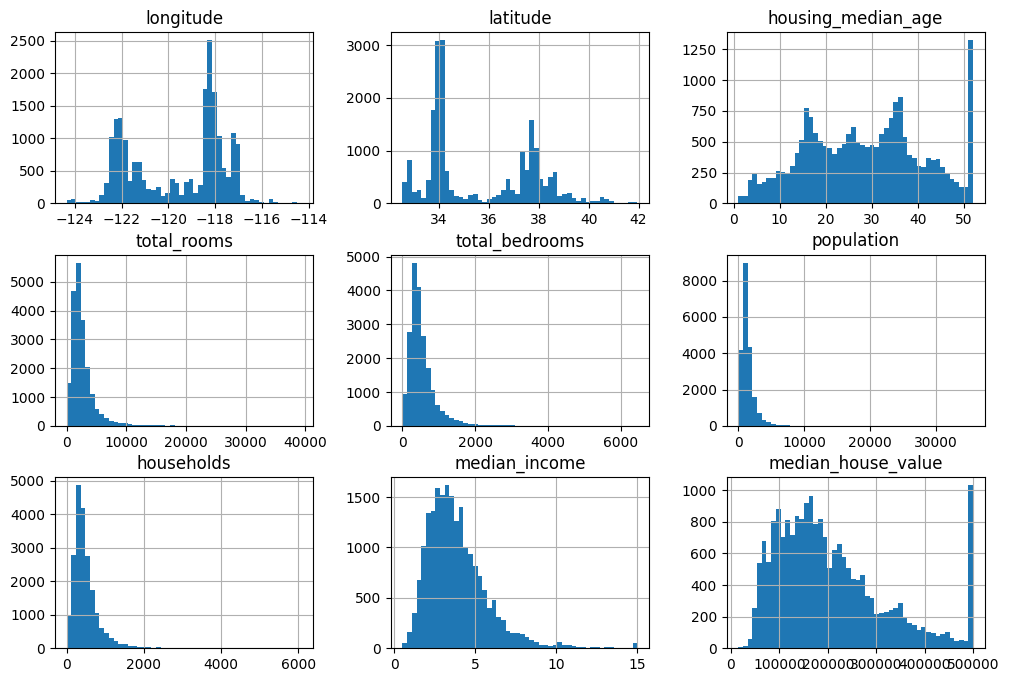

In [7]:
housing.hist(bins=50, figsize=(12,8))
plt.show()

### Observations about the data

1. `median_income` is capped at 15 and it represents `15 - 150000`
2. Working with preprocessed attributes is common in machine learning, and it is not necessarily a problem, but you should try to understand how the data was computed.
3. `Housing median age` & `median house value` is also capped
4. `Median house value` is our `target label` but since it is capped, we have 2 options: 
    - Get the proper labels for the capped values
    - Remove the districts from the training and the test set to avoid wrong predictions above the 500000 mark

### Split the data into train & test sets

    1. Random split - Using train_test_split()
    2. Stratified sampling - StratifiedShuffleSplit or with the `stratify` argument for the `train_test_split`

In [8]:
# Divide the data into stratas (i.e small data groups)
housing["income_category"] = pd.cut(housing['median_income'],
                                   bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                                   labels=[1,2,3,4,5])

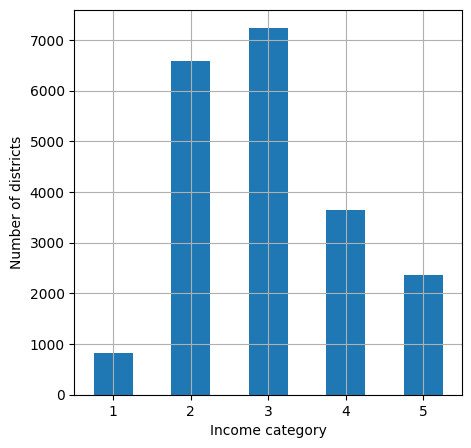

In [9]:
plt.figure(figsize=(5,5))
housing['income_category'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [10]:
strat_train_set, strat_test_set = train_test_split(housing,
                                                  test_size=0.2,
                                                  stratify=housing['income_category'],
                                                  random_state=42)

In [11]:
strat_test_set['income_category'].value_counts()

income_category
3    1447
2    1316
4     728
5     472
1     165
Name: count, dtype: int64

In [12]:
# Drop the income category
strat_train_set.drop("income_category", axis=1, inplace=True)
strat_test_set.drop("income_category", axis=1, inplace=True)

## Explore & Visualize the data to gain insights

In [13]:
# Make a copy of the original training set
housing = strat_train_set.copy()

    Since the data has latitiudes and longitudes, it is a good idea to create a scatter plot of all the districts to visualize the data.
    The scatter plot will look like the map of California

#### Basic scatter plot

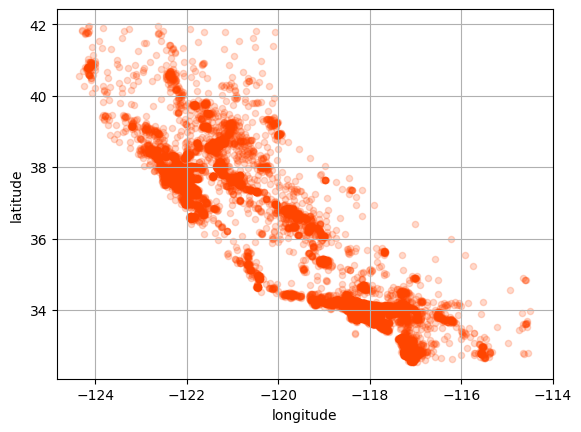

In [14]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, color="orangered", alpha=0.2)
plt.show()

#### Advanced Scatter Plot

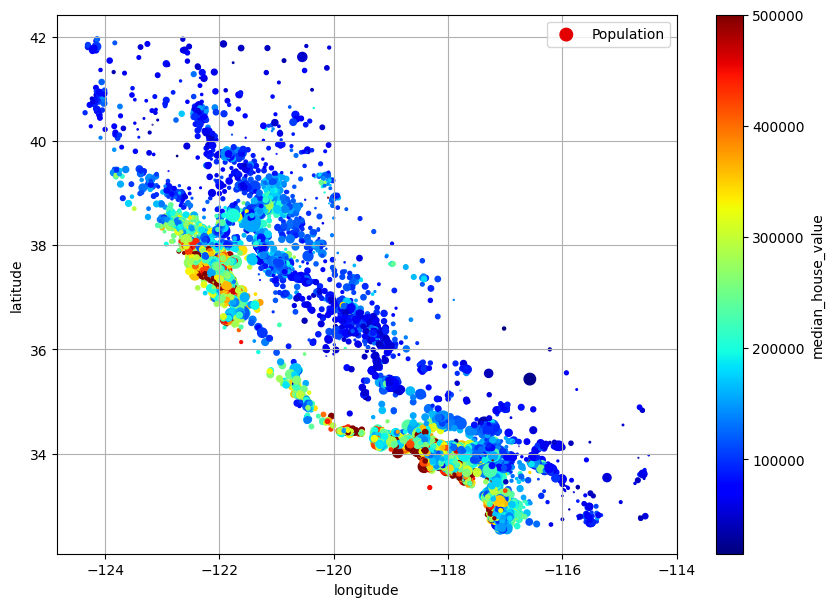

In [15]:
housing.plot(kind="scatter",
            x="longitude",y="latitude",
            grid=True,
            s=housing['population']/100, label="Population",
            c="median_house_value", cmap="jet", colorbar=True,
            legend=True, sharex=False, figsize=(10,7))
plt.show()

### Correlation between attributes

    Pearson's Correlation Coefficient
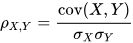

In [16]:
corr_matrix = housing.corr(numeric_only=True)

In [17]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

### Pandas: scatter_matrix()

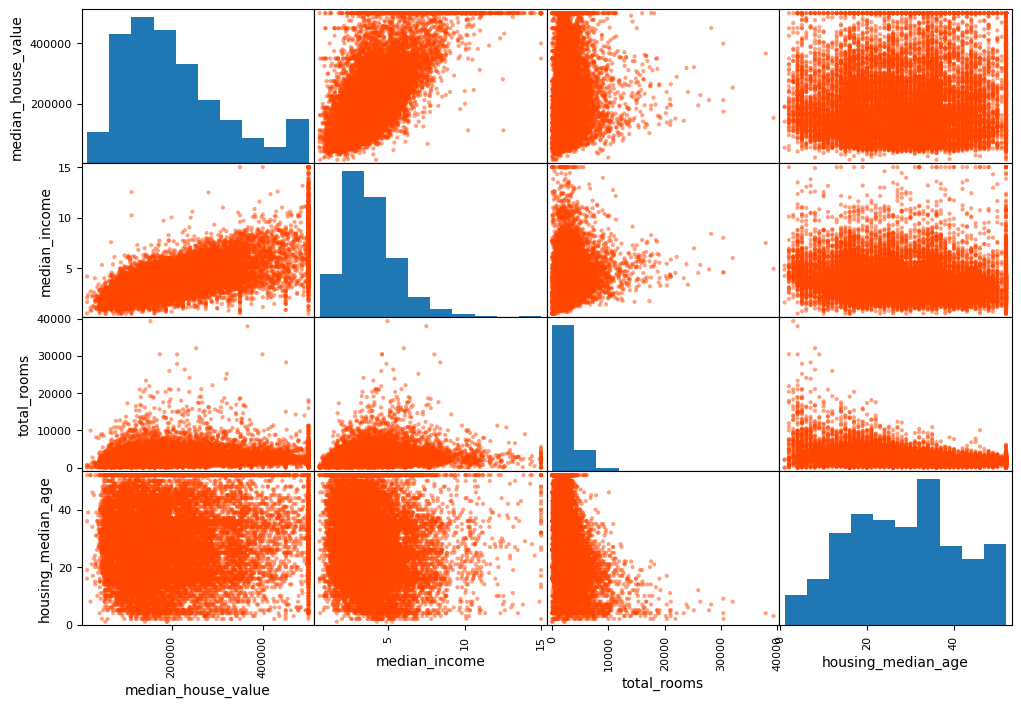

In [18]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms','housing_median_age']
scatter_matrix(housing[attributes], figsize=(12,8), color="orangered")
plt.show()

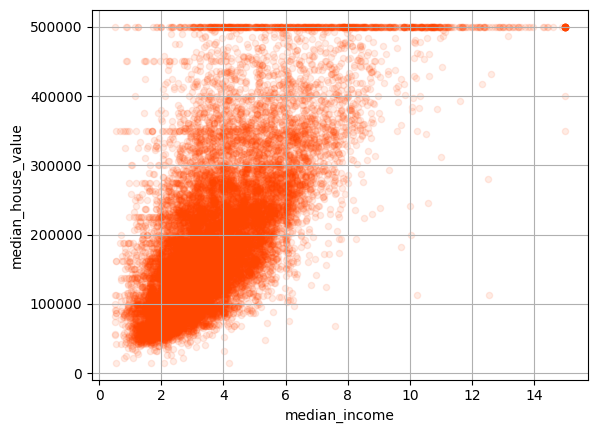

In [19]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", color="orangered", grid=True, alpha=0.1)
plt.show()

### Attribute combinations: Add new attributes to the dataframe

In [20]:
housing['rooms_per_house'] = housing['total_rooms'] / housing['households']
housing['bedrooms_ratio'] = housing['total_bedrooms'] / housing['total_rooms']
housing['people_per_house'] = housing['population'] / housing['households']

In [21]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_house,bedrooms_ratio,people_per_house
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY,3.211799,0.335742,1.524178
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN,5.504202,0.180153,1.865546
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND,5.334975,0.200369,2.768473
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND,5.351282,0.203881,2.365385
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN,3.725256,0.277371,1.631399


In [22]:
corr_matrix_new_attrs = housing.corr(numeric_only=True)
corr_matrix_new_attrs['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

### Some observations

1. The maximum correlated attributes to the median_house_value are - median_income & rooms_per_house
2. The population is scattered differently across the map of California but the scatter plot with the population distribution gives a fair idea of the distribution

## Prepare the data for Machine Learning Algorithms

In [23]:
# A clean copy of the dataset
housing = strat_train_set.drop("median_house_value", axis = 1)
housing_labels = strat_train_set['median_house_value'].copy()

In [24]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 13096 to 19888
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16344 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


### Deal with null values
1. Drop the entries(districts) - rows
2. Drop the column(attribute) - column
3. Imputation: Replace the null values with mean/median/mode

#### Part 1 - Numerical attributes

In [25]:
imputation_housing = housing.copy()
median = imputation_housing['total_bedrooms'].median()
imputation_housing['total_bedrooms'].fillna(median, inplace=True)

/var/folders/f2/j66wx7px7sx9qrws63ymk_sr0000gn/T/ipykernel_89407/2709529695.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  imputation_housing['total_bedrooms'].fillna(median, inplace=True)


In [26]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

In [27]:
# Create a dataset of only numeric attributes
housing_num = housing.select_dtypes(include=[np.number])

In [28]:
imputer.fit(housing_num)

,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False


#### Imputer

The imputer stores the median of all the attributes in the `statistics_` instance to be used even later on any of the attributes in the test or validation sets

In [29]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [30]:
housing_num.median()

longitude             -118.5100
latitude                34.2600
housing_median_age      29.0000
total_rooms           2125.0000
total_bedrooms         434.0000
population            1167.0000
households             408.0000
median_income            3.5385
dtype: float64

In [31]:
# Transform the dataset
X = imputer.transform(housing_num)

In [32]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292


#### Part 2 - Handling Text and Categorical attributes

In [33]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(8)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


In [34]:
# Convert the categorical attribute to numerical values
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [35]:
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [36]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

#### One hot encoding

sparse_output = False: This will output one-hot encoding as a numpy array

In [37]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = onehot_encoder.fit_transform(housing_cat)

In [38]:
housing_cat_1hot

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [39]:
onehot_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Feature Scaling

    1. Min-max scalar
    2. Standardization

In [40]:
from sklearn.preprocessing import MinMaxScaler

min_max_scalar = MinMaxScaler(feature_range=(-1, 1))
housing_minmax_scaled = min_max_scalar.fit_transform(housing_num)

In [41]:
from sklearn.preprocessing import StandardScaler

standard_scalar = StandardScaler()
housing_num_std_scaled = standard_scalar.fit_transform(housing_num)

#### Heavy tail - Transformation & feature scaling

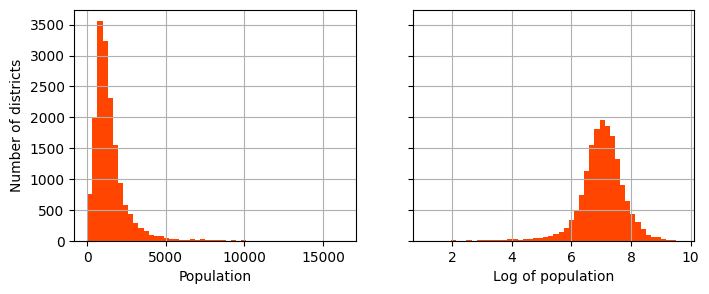

In [42]:
# Population attribute
fig, axs = plt.subplots(1, 2, figsize=(8,3), sharey=True)
housing['population'].hist(ax=axs[0], bins=50, color="orangered")
housing['population'].apply(np.log).hist(ax=axs[1], bins=50, color="orangered")

axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
plt.show()

In [43]:
print("Max population: ", housing['population'].max())

Max population:  16305.0


#### Transform the label column

In [44]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression

model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())
model.fit(housing[['median_income']], housing_labels)

,regressor,LinearRegression()
,transformer,StandardScaler()
,func,None
,inverse_func,None
,check_inverse,True
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False
,copy,True


### Custom Transformers

##### Important parameters: 
1. Transformation function
2. Inverse transformation function

In [ ]:
# Custom transformer - Log operation on the population attribute
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
transformed_pop = log_transformer.transform(housing[['population']])

In [46]:
transformed_pop.head()

,population
13096,7.362645
14973,6.501290
3785,6.331502
14689,7.520235
20507,7.555905


#### Clustering - Custom class

In [47]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        # Always return self!
        return self

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [48]:
cluster_sim = ClusterSimilarity(n_clusters=10, gamma=1.0, random_state=42)
similarities = cluster_sim.fit_transform(housing[["latitude", "longitude"]],
                                        sample_weight = housing_labels)

In [49]:
similarities[:3].round(2)

array([[0.08, 0.  , 0.6 , 0.  , 0.  , 0.99, 0.  , 0.  , 0.  , 0.14],
       [0.  , 0.99, 0.  , 0.04, 0.  , 0.  , 0.11, 0.  , 0.63, 0.  ],
       [0.44, 0.  , 0.3 , 0.  , 0.  , 0.7 , 0.  , 0.01, 0.  , 0.29]])

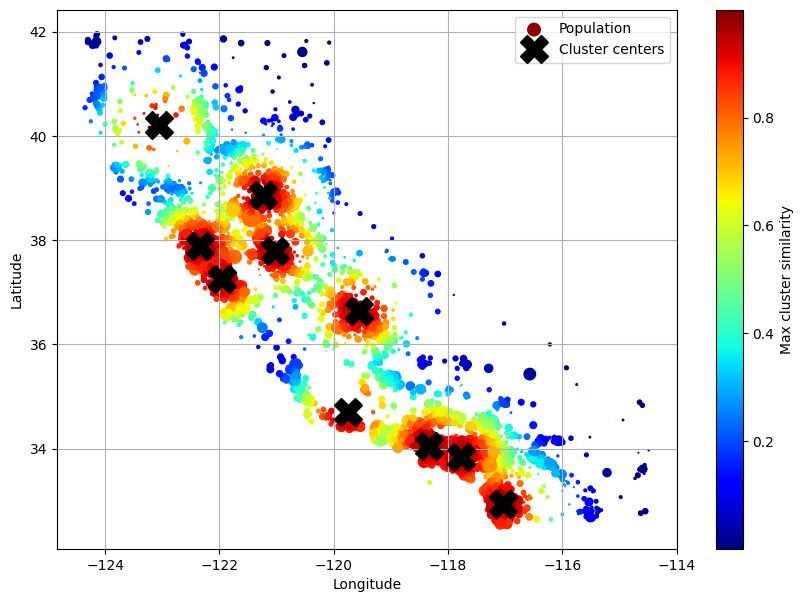

In [50]:
housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed["Max cluster similarity"] = similarities.max(axis=1)

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
                     s=housing_renamed["Population"] / 100, label="Population",
                     c="Max cluster similarity",
                     cmap="jet", colorbar=True,
                     legend=True, sharex=False, figsize=(10, 7))

# Cross marks
plt.plot(cluster_sim.kmeans_.cluster_centers_[:, 1],
         cluster_sim.kmeans_.cluster_centers_[:, 0],
         linestyle="", color="black", marker="X", markersize=20,
         label="Cluster centers")
plt.legend(loc="upper right")
plt.show()

### Transformation pipelines

#### Separate pipelines for data handling

In [53]:
from sklearn.pipeline import Pipeline, make_pipeline

sklearn.set_config(display="diagram")
# Approach 1
num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler())
])

# Approach 2
# num_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
num_pipeline

,steps,"[('impute', ...), ('standardize', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


In [63]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
print(f"Type of \"housing_num_prepared\": {type(housing_num_prepared)}")

# Round the values upto 2 decimal places
housing_num_prepared[:2].round(2)

Type of "housing_num_prepared": <class 'numpy.ndarray'>


array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

#### Prepare a dataframe from a numpy array transformed by transformer

In [65]:
# Prepare a dataframe
df_housing_num_prepared = pd.DataFrame(housing_num_prepared, columns=num_pipeline.get_feature_names_out(), index=housing_num.index)

In [71]:
print(f"Feature names out function output - {num_pipeline.get_feature_names_out()}\n")
print(f"Index - {housing_num.index}")

Feature names out function output - ['longitude' 'latitude' 'housing_median_age' 'total_rooms'
 'total_bedrooms' 'population' 'households' 'median_income']

Index - Index([13096, 14973,  3785, 14689, 20507,  1286, 18078,  4396, 18031,  6753,
       ...
       11877, 17004,  1894,  6234,  7071, 14207, 13105, 19301, 19121, 19888],
      dtype='int64', length=16512)


In [93]:
print(f"\n{'-' * 100}")
logger("Before pipeline transformation", housing_num.head())
print(f"\n{'-' * 100}")
logger("After pipeline transformation", df_housing_num_prepared.head())
print(f"\n{'-' * 100}")


----------------------------------------------------------------------------------------------------
Before pipeline transformation
        longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096    -122.42     37.80                52.0       3321.0          1115.0   
14973    -118.38     34.14                40.0       1965.0           354.0   
3785     -121.98     38.36                33.0       1083.0           217.0   
14689    -117.11     33.75                17.0       4174.0           851.0   
20507    -118.15     33.77                36.0       4366.0          1211.0   

       population  households  median_income  
13096      1576.0      1034.0         2.0987  
14973       666.0       357.0         6.0876  
3785        562.0       203.0         2.4330  
14689      1845.0       780.0         2.2618  
20507      1912.0      1172.0         3.5292  

----------------------------------------------------------------------------------------------------
After p

### ColumnTransformer - Single transformer to handle different types of attributes

In [ ]:
from sklearn.compose import ColumnTransformer

num_attrs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attrs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

preprocessing = ColumnTransformer([
    ("Numerical_transformer", num_pipeline, num_attrs),
    ("Categorical_transformer", cat_pipeline, cat_attrs),
])

preprocessing

,transformers,"[('Numerical_transformer', ...), ('Categorical_transformer', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [103]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object))
)

preprocessing

,transformers,"[('pipeline-1', ...), ('pipeline-2', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [110]:
housing_prepared = preprocessing.fit_transform(housing)
type(housing_prepared)

numpy.ndarray

In [113]:
# Transforming a numpy array to dataframe

df_housing_prepared = pd.DataFrame(housing_prepared, columns=preprocessing.get_feature_names_out(), index=housing.index)
df_housing_prepared.head()

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,0.0,0.0,0.0,1.0,0.0
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,1.0,0.0,0.0,0.0,0.0
3785,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789,0.0,1.0,0.0,0.0,0.0
14689,1.231216,-0.884924,-0.919891,0.702262,0.742306,0.383175,0.731375,-0.850281,0.0,1.0,0.0,0.0,0.0
20507,0.711362,-0.875549,0.589800,0.790125,1.595753,0.444376,1.755263,-0.180365,0.0,0.0,0.0,0.0,1.0


## Custom preprocessing for dataset

In [122]:
# Function to return the ratio of 2 complete columns(for adding new attributes)
def column_ratio(X):
    return X[:, [0]]/X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]

def ratio_pipeline():
    ratio_pipeline = make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())
    return ratio_pipeline

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())

cluster_simil= ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler())

preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
    ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
    ("people_per_house", ratio_pipeline(), ["population", "households"]),
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
    ("geo", cluster_simil, ["latitude", "longitude"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
], remainder=default_num_pipeline) # 1 column remains: housing_median_age

In [123]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 24)

In [124]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

In [126]:
df_final_housing = pd.DataFrame(housing_prepared, columns=preprocessing.get_feature_names_out(), index=housing.index)
df_final_housing.head()

,bedrooms__ratio,rooms_per_house__ratio,people_per_house__ratio,log__total_bedrooms,log__total_rooms,log__population,log__households,log__median_income,geo__Cluster 0 similarity,geo__Cluster 1 similarity,...,geo__Cluster 6 similarity,geo__Cluster 7 similarity,geo__Cluster 8 similarity,geo__Cluster 9 similarity,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN,remainder__housing_median_age
13096,1.846624,-0.866027,-0.330204,1.324114,0.637892,0.456906,1.310369,-1.071522,8.708837e-08,9.712456e-01,...,7.114441e-04,3.070969e-17,1.314047e-01,5.740031e-01,0.0,0.0,0.0,1.0,0.0,1.861119
14973,-0.508121,0.024550,-0.253616,-0.252671,-0.063576,-0.711654,-0.142030,1.194712,1.181328e-01,9.738096e-14,...,3.045359e-27,5.437838e-01,1.735342e-09,2.275194e-10,1.0,0.0,0.0,0.0,0.0,0.907630
3785,-0.202155,-0.041193,-0.051041,-0.925266,-0.859927,-0.941997,-0.913030,-0.756981,2.295286e-08,7.457782e-01,...,4.750719e-03,1.605970e-17,2.744847e-01,2.839978e-01,0.0,1.0,0.0,0.0,0.0,0.351428
14689,-0.149006,-0.034858,-0.141475,0.952773,0.943475,0.670700,0.925373,-0.912253,4.618947e-04,3.873884e-20,...,2.916178e-35,7.405721e-01,2.243339e-14,4.218649e-16,0.0,1.0,0.0,0.0,0.0,-0.919891
20507,0.963208,-0.666554,-0.306148,1.437622,1.003590,0.719093,1.481464,0.034537,3.166634e-02,7.905346e-16,...,2.843975e-30,7.501278e-01,2.890866e-11,3.710912e-12,0.0,0.0,0.0,0.0,1.0,0.589800


## Select and Train a Model

Now that we have sampled a training and test set, preprocessed the data uisng a custom preprocessing pipeline.<br>
Now we can select and train a machine learning model

### Linear Regression

In [127]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

,steps,"[('columntransformer', ...), ('linearregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('bedrooms', ...), ('rooms_per_house', ...), ...]"
,remainder,Pipeline(step...ardScaler())])
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [138]:
housing_predictions = lin_reg.predict(housing)
print(f"Housing predictions: {housing_predictions[:5].round(2)}")
print(f"Housing predictions: {housing_labels[:5].values}")

Housing predictions: [242761.81 375862.79 127480.98  99355.3  324610.74]
Housing predictions: [458300. 483800. 101700.  96100. 361800.]


#### RMSE - Metrics

In [139]:
from sklearn.metrics import root_mean_squared_error

lin_rmse = root_mean_squared_error(housing_labels, housing_predictions)
lin_rmse

68647.95686706656

### Decision Tree regressor

In [140]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

,steps,"[('columntransformer', ...), ('decisiontreeregressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('bedrooms', ...), ('rooms_per_house', ...), ...]"
,remainder,Pipeline(step...ardScaler())])
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [141]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = root_mean_squared_error(housing_predictions, housing_labels)
tree_rmse

0.0

In [144]:
# K-fold cross validation

from sklearn.model_selection import cross_val_score
tree_rmses_crossval = -cross_val_score(tree_reg, housing, housing_labels, cv=10, scoring="neg_root_mean_squared_error")
tree_rmses_crossval

array([64854.86006934, 63557.65500684, 65663.3837676 , 65453.91538918,
       64456.37635524, 66919.47216599, 66110.41040337, 68532.21066423,
       69530.30110106, 68591.25110456])

In [148]:
pd.Series(tree_rmses_crossval).describe().round(2)

count       10.00
mean     66366.98
std       1976.84
min      63557.66
25%      65004.62
50%      65886.90
75%      68129.03
max      69530.30
dtype: float64

### Random Forests

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
# Evaluate k-fold cross validation
forest_rmses_crossval = -cross_val_score(forest_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(forest_rmses_crossval).describe().round(2)

count       10.00
mean     46938.21
std       1018.40
min      45522.65
25%      46291.33
50%      47021.70
75%      47321.52
max      49140.83
dtype: float64

### Grid Search

In [152]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42))
])

# The parameters are split at __
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid=param_grid, cv=3, scoring="neg_root_mean_squared_error")
grid_search.fit(housing, housing_labels)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"[{'preprocessing__geo__n_clusters': [5, 8, ...], 'random_forest__max_features': [4, 6, ...]}, {'preprocessing__geo__n_clusters': [10, 15], 'random_forest__max_features': [6, 8, ...]}]"
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('bedrooms', ...), ('rooms_per_house', ...), ...]"


In [154]:
# Best hyperparameters through grid search

grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [176]:
cv_res = pd.DataFrame(grid_search.cv_results_)
# Sorting it in descending order(since rmse values are negative)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,43012,43683,44158,43618
13,15,8,43697,44017,44819,44178
7,10,6,43710,44133,45238,44360
9,10,6,43710,44133,45238,44360
6,10,4,43803,44232,45094,44376


### Randomized Search

In [177]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'preprocessing__geo__n_clusters': randint(low=3, high=50),
    'random_forest__max_features': randint(low=2, high=20)
}

random_search = RandomizedSearchCV(full_pipeline, param_distributions=param_dist, n_iter=10,
                                   cv=3, scoring='neg_root_mean_squared_error', random_state=42)
random_search.fit(housing, housing_labels)

,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'preprocessing__geo__n_clusters': <scipy.stats....t 0x14a8a7040>, 'random_forest__max_features': <scipy.stats....t 0x14a8a4e50>}"
,n_iter,10
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


## Importance of different attributes

In [179]:
final_model = random_search.best_estimator_
feature_importances = final_model['random_forest'].feature_importances_
feature_importances.round(2)

array([0.06, 0.05, 0.05, 0.01, 0.01, 0.01, 0.01, 0.19, 0.01, 0.01, 0.02,
       0.04, 0.01, 0.  , 0.02, 0.01, 0.01, 0.01, 0.02, 0.01, 0.  , 0.01,
       0.01, 0.01, 0.01, 0.02, 0.02, 0.01, 0.01, 0.01, 0.02, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.01, 0.02, 0.01, 0.01, 0.02,
       0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.01, 0.01, 0.01, 0.  , 0.08,
       0.  , 0.  , 0.  , 0.01])

In [182]:
final_model['preprocessing'].get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'geo__Cluster 10 similarity',
       'geo__Cluster 11 similarity', 'geo__Cluster 12 similarity',
       'geo__Cluster 13 similarity', 'geo__Cluster 14 similarity',
       'geo__Cluster 15 similarity', 'geo__Cluster 16 similarity',
       'geo__Cluster 17 similarity', 'geo__Cluster 18 similarity',
       'geo__Cluster 19 similarity', 'geo__Cluster 20 similarity',
       'geo__Cluster 21 similarity', 'geo__Cluster 22 similarity',
       'geo__Cluster 23 similarity', 'ge

In [187]:
sorted(zip(feature_importances, final_model['preprocessing'].get_feature_names_out()), reverse=True)

[(np.float64(0.18901772752260965), 'log__median_income'),
 (np.float64(0.07519718294444783), 'cat__ocean_proximity_INLAND'),
 (np.float64(0.06368885514209106), 'bedrooms__ratio'),
 (np.float64(0.052269006448954984), 'rooms_per_house__ratio'),
 (np.float64(0.04648465413462927), 'people_per_house__ratio'),
 (np.float64(0.04284851790565368), 'geo__Cluster 3 similarity'),
 (np.float64(0.023328049652780496), 'geo__Cluster 17 similarity'),
 (np.float64(0.022238253533182), 'geo__Cluster 18 similarity'),
 (np.float64(0.022194673655250526), 'geo__Cluster 22 similarity'),
 (np.float64(0.01859877667208851), 'geo__Cluster 40 similarity'),
 (np.float64(0.01780189964394329), 'geo__Cluster 10 similarity'),
 (np.float64(0.01730806454731114), 'geo__Cluster 41 similarity'),
 (np.float64(0.016888879511081256), 'geo__Cluster 35 similarity'),
 (np.float64(0.01628583573372508), 'geo__Cluster 6 similarity'),
 (np.float64(0.015846054619681672), 'geo__Cluster 2 similarity'),
 (np.float64(0.015393321731047401),

## Evaluate the model on test set

In [198]:
x_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(x_test)
final_rmse = root_mean_squared_error(y_test, final_predictions)
print(final_rmse)

41533.23764903072


## Save the model for production

In [203]:
import joblib

joblib.dump(final_model, "my_california_housing_model.pkl")

['my_california_housing_model.pkl']